# Test of Predictive Analysis via RL

In [14]:
#Yahoo finaince not working any longer
#from yahoo_finance import Share
from enum import Enum

import matplotlib.pyplot as plt
import numpy as np
import random
import datetime
import tensorflow as tf
from tensorflow.python.framework import ops

plt.rcParams['figure.figsize'] = [26, 16]

In [2]:
class Column(Enum):
    DATE = 0
    OPEN = 1
    HIGH = 2
    LOW = 3
    CLOSE = 4
    ADJCLOSE = 5
    VOLUME = 6


In [3]:
start_date_global = '2000-07-01'
end_date_global = '2017-07-01'
#stock_name = 'BTC-USD'
#stock_name = 'ETH-USD'
stock_name = 'MSFT'
arrow_size = 10

In [4]:
def getStockDataVec(key, column, start_date=None, end_date=None):
    vec = []
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    
    lines = open("data/" + key + ".csv", "r").read().splitlines()
    for line in lines[1:]:
        tval = line.split(",")
        #Date,Open,High,Low,Close,Adj Close,Volume
        cur_date = datetime.datetime.strptime(tval[0], "%Y-%m-%d")
        if((start_date != None and end_date!=None and cur_date >= start_date and cur_date <= end_date) or
          (start_date == None and end_date == None)):
            if column.value == 0:
                vec.append(str(tval[column.value]))
            elif column.value == 1 or column.value == 2 or column.value == 3 or column.value == 4 or column.value == 5:
                vec.append(float(tval[column.value]))
            elif column.value == 6:
                vec.append(int(tval[column.value]))
        
    return vec

In [5]:
#btcusd = getStockDataVec(stock_name,Column.CLOSE)
#print(btcusd[:])

In [6]:
btcusd_dates = getStockDataVec(stock_name,Column.DATE, start_date_global, end_date_global)
btcusd_dates

['2000-07-03',
 '2000-07-05',
 '2000-07-06',
 '2000-07-07',
 '2000-07-10',
 '2000-07-11',
 '2000-07-12',
 '2000-07-13',
 '2000-07-14',
 '2000-07-17',
 '2000-07-18',
 '2000-07-19',
 '2000-07-20',
 '2000-07-21',
 '2000-07-24',
 '2000-07-25',
 '2000-07-26',
 '2000-07-27',
 '2000-07-28',
 '2000-07-31',
 '2000-08-01',
 '2000-08-02',
 '2000-08-03',
 '2000-08-04',
 '2000-08-07',
 '2000-08-08',
 '2000-08-09',
 '2000-08-10',
 '2000-08-11',
 '2000-08-14',
 '2000-08-15',
 '2000-08-16',
 '2000-08-17',
 '2000-08-18',
 '2000-08-21',
 '2000-08-22',
 '2000-08-23',
 '2000-08-24',
 '2000-08-25',
 '2000-08-28',
 '2000-08-29',
 '2000-08-30',
 '2000-08-31',
 '2000-09-01',
 '2000-09-05',
 '2000-09-06',
 '2000-09-07',
 '2000-09-08',
 '2000-09-11',
 '2000-09-12',
 '2000-09-13',
 '2000-09-14',
 '2000-09-15',
 '2000-09-18',
 '2000-09-19',
 '2000-09-20',
 '2000-09-21',
 '2000-09-22',
 '2000-09-25',
 '2000-09-26',
 '2000-09-27',
 '2000-09-28',
 '2000-09-29',
 '2000-10-02',
 '2000-10-03',
 '2000-10-04',
 '2000-10-

In [7]:
def plot_prices(prices, buytrigger=None, selltrigger=None):
    plt.title('Opening Crypto Prices')
    plt.xlabel('iteration')
    plt.ylabel('price ($)')
    plt.plot(prices)
    
    if buytrigger.size > 0:
        plt.plot(buytrigger[:,0], buytrigger[:,1],'^', markersize=arrow_size, color='g')
    if selltrigger.size > 0:
        plt.plot(selltrigger[:,0], selltrigger[:,1],'v', markersize=arrow_size, color='r')
    plt.savefig('prices.png')

## Setup our ABC for our policies

In [8]:
class DecisionPolicy:
    def select_action(self, current_state, step):
        pass
    
    def update_q(self, state, action, reward, next_state):
        pass

## Allow us to just do a simple random policy which will allow for a baseline comparison for our model later when comparing to QLearning approach and others
#### Randomly picks an 'action' without looking at the 'state'

In [9]:
class RandomDecisionPolicy(DecisionPolicy):
    def __init__(self, actions):
        self.actions = actions
        
    def select_action(self, current_state, step):
        action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

## Go about setting up a QLearning decision policy
#### Will allow us to setup a learned / more robust decision policy via TF

In [10]:
class QLearningDecisionPolicy(DecisionPolicy):
    def __init__(self, actions, input_dim):
        self.epsilon = 0.5
        self.gamma = 0.001
        self.actions = actions
        output_dim = len(actions)
        h1_dim = 200

        self.x = tf.placeholder(tf.float32, [None, input_dim])
        self.y = tf.placeholder(tf.float32, [output_dim])
        W1 = tf.Variable(tf.random_normal([input_dim, h1_dim]))
        b1 = tf.Variable(tf.constant(0.1, shape=[h1_dim]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)
        W2 = tf.Variable(tf.random_normal([h1_dim, output_dim]))
        b2 = tf.Variable(tf.constant(0.1, shape=[output_dim]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())

    def select_action(self, current_state, step):
        threshold = min(self.epsilon, step / 1000.)
        if random.random() < threshold:
            # Exploit best option with probability epsilon
            action_q_vals = self.sess.run(self.q, feed_dict={self.x: current_state})
            action_idx = np.argmax(action_q_vals)  # TODO: replace w/ tensorflow's argmax
            action = self.actions[action_idx]
        else:
            # Explore random option with probability 1 - epsilon
            action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action

    def update_q(self, state, action, reward, next_state):
        action_q_vals = self.sess.run(self.q, feed_dict={self.x: state})
        next_action_q_vals = self.sess.run(self.q, feed_dict={self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        action_q_vals[0, next_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        self.sess.run(self.train_op, feed_dict={self.x: state, self.y: action_q_vals})


In [11]:
def run_simulation(policy, initial_budget, initial_num_stocks, prices, hist, num_try=0, debug=False):
    budget = initial_budget
    num_stocks = initial_num_stocks
    share_value = 0
    transitions = list()
    buytriggers = list()
    selltriggers = list()
    for i in range(len(prices) - hist - 1):
        if i % 100 == 0:
            print('try {} - progress {:.2f}%'.format(num_try, float(100*i) / (len(prices) - hist - 1)))
        current_state = np.asmatrix(np.hstack((prices[i:i+hist], budget, num_stocks)))
        current_portfolio = budget + num_stocks * share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + hist + 1])
        
        if action == 'Buy' and budget >= share_value:
            budget -= share_value
            num_stocks += 1
            buytriggers.append((i, prices[i]))
        elif action == 'Sell' and num_stocks > 0:
            budget += share_value
            num_stocks -= 1
            selltriggers.append((i, prices[i]))
        else: 
            action = 'Hold'
        new_portfolio = budget + num_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+hist+1], budget, num_stocks)))
        transitions.append((current_state, action, reward, next_state))
        policy.update_q(current_state, action, reward, next_state)
        
    portfolio = budget + num_stocks * share_value
    if debug:
        print('${}\t{} shares'.format(budget, num_stocks))
    return portfolio, np.array(buytriggers), np.array(selltriggers)

## Run our model a number of times to then get the best mean across the runs which will provide a more reliable result

In [12]:
def run_simulations(policy, budget, num_stocks, prices, hist):
    num_tries = 100
    final_portfolios = list()
    for i in range(num_tries):
        final_portfolio, _, __ = run_simulation(policy, budget, num_stocks, prices, hist, i)
        final_portfolios.append(final_portfolio)
    avg, std = np.mean(final_portfolios), np.std(final_portfolios)
    return avg, std, _, __

try 0 - progress 0.00%
try 0 - progress 2.45%
try 0 - progress 4.91%
try 0 - progress 7.36%
try 0 - progress 9.82%
try 0 - progress 12.27%
try 0 - progress 14.72%
try 0 - progress 17.18%
try 0 - progress 19.63%
try 0 - progress 22.09%
try 0 - progress 24.54%
try 0 - progress 26.99%
try 0 - progress 29.45%
try 0 - progress 31.90%
try 0 - progress 34.36%
try 0 - progress 36.81%
try 0 - progress 39.26%
try 0 - progress 41.72%
try 0 - progress 44.17%
try 0 - progress 46.63%
try 0 - progress 49.08%
try 0 - progress 51.53%
try 0 - progress 53.99%
try 0 - progress 56.44%
try 0 - progress 58.90%
try 0 - progress 61.35%
try 0 - progress 63.80%
try 0 - progress 66.26%
try 0 - progress 68.71%
try 0 - progress 71.17%
try 0 - progress 73.62%
try 0 - progress 76.07%
try 0 - progress 78.53%
try 0 - progress 80.98%
try 0 - progress 83.44%
try 0 - progress 85.89%
try 0 - progress 88.34%
try 0 - progress 90.80%
try 0 - progress 93.25%
try 0 - progress 95.71%
try 0 - progress 98.16%
try 1 - progress 0.00

try 8 - progress 39.26%
try 8 - progress 41.72%
try 8 - progress 44.17%
try 8 - progress 46.63%
try 8 - progress 49.08%
try 8 - progress 51.53%
try 8 - progress 53.99%
try 8 - progress 56.44%
try 8 - progress 58.90%
try 8 - progress 61.35%
try 8 - progress 63.80%
try 8 - progress 66.26%
try 8 - progress 68.71%
try 8 - progress 71.17%
try 8 - progress 73.62%
try 8 - progress 76.07%
try 8 - progress 78.53%
try 8 - progress 80.98%
try 8 - progress 83.44%
try 8 - progress 85.89%
try 8 - progress 88.34%
try 8 - progress 90.80%
try 8 - progress 93.25%
try 8 - progress 95.71%
try 8 - progress 98.16%
try 9 - progress 0.00%
try 9 - progress 2.45%
try 9 - progress 4.91%
try 9 - progress 7.36%
try 9 - progress 9.82%
try 9 - progress 12.27%
try 9 - progress 14.72%
try 9 - progress 17.18%
try 9 - progress 19.63%
try 9 - progress 22.09%
try 9 - progress 24.54%
try 9 - progress 26.99%
try 9 - progress 29.45%
try 9 - progress 31.90%
try 9 - progress 34.36%
try 9 - progress 36.81%
try 9 - progress 39.2

try 16 - progress 51.53%
try 16 - progress 53.99%
try 16 - progress 56.44%
try 16 - progress 58.90%
try 16 - progress 61.35%
try 16 - progress 63.80%
try 16 - progress 66.26%
try 16 - progress 68.71%
try 16 - progress 71.17%
try 16 - progress 73.62%
try 16 - progress 76.07%
try 16 - progress 78.53%
try 16 - progress 80.98%
try 16 - progress 83.44%
try 16 - progress 85.89%
try 16 - progress 88.34%
try 16 - progress 90.80%
try 16 - progress 93.25%
try 16 - progress 95.71%
try 16 - progress 98.16%
try 17 - progress 0.00%
try 17 - progress 2.45%
try 17 - progress 4.91%
try 17 - progress 7.36%
try 17 - progress 9.82%
try 17 - progress 12.27%
try 17 - progress 14.72%
try 17 - progress 17.18%
try 17 - progress 19.63%
try 17 - progress 22.09%
try 17 - progress 24.54%
try 17 - progress 26.99%
try 17 - progress 29.45%
try 17 - progress 31.90%
try 17 - progress 34.36%
try 17 - progress 36.81%
try 17 - progress 39.26%
try 17 - progress 41.72%
try 17 - progress 44.17%
try 17 - progress 46.63%
try 1

try 24 - progress 61.35%
try 24 - progress 63.80%
try 24 - progress 66.26%
try 24 - progress 68.71%
try 24 - progress 71.17%
try 24 - progress 73.62%
try 24 - progress 76.07%
try 24 - progress 78.53%
try 24 - progress 80.98%
try 24 - progress 83.44%
try 24 - progress 85.89%
try 24 - progress 88.34%
try 24 - progress 90.80%
try 24 - progress 93.25%
try 24 - progress 95.71%
try 24 - progress 98.16%
try 25 - progress 0.00%
try 25 - progress 2.45%
try 25 - progress 4.91%
try 25 - progress 7.36%
try 25 - progress 9.82%
try 25 - progress 12.27%
try 25 - progress 14.72%
try 25 - progress 17.18%
try 25 - progress 19.63%
try 25 - progress 22.09%
try 25 - progress 24.54%
try 25 - progress 26.99%
try 25 - progress 29.45%
try 25 - progress 31.90%
try 25 - progress 34.36%
try 25 - progress 36.81%
try 25 - progress 39.26%
try 25 - progress 41.72%
try 25 - progress 44.17%
try 25 - progress 46.63%
try 25 - progress 49.08%
try 25 - progress 51.53%
try 25 - progress 53.99%
try 25 - progress 56.44%
try 2

try 32 - progress 68.71%
try 32 - progress 71.17%
try 32 - progress 73.62%
try 32 - progress 76.07%
try 32 - progress 78.53%
try 32 - progress 80.98%
try 32 - progress 83.44%
try 32 - progress 85.89%
try 32 - progress 88.34%
try 32 - progress 90.80%
try 32 - progress 93.25%
try 32 - progress 95.71%
try 32 - progress 98.16%
try 33 - progress 0.00%
try 33 - progress 2.45%
try 33 - progress 4.91%
try 33 - progress 7.36%
try 33 - progress 9.82%
try 33 - progress 12.27%
try 33 - progress 14.72%
try 33 - progress 17.18%
try 33 - progress 19.63%
try 33 - progress 22.09%
try 33 - progress 24.54%
try 33 - progress 26.99%
try 33 - progress 29.45%
try 33 - progress 31.90%
try 33 - progress 34.36%
try 33 - progress 36.81%
try 33 - progress 39.26%
try 33 - progress 41.72%
try 33 - progress 44.17%
try 33 - progress 46.63%
try 33 - progress 49.08%
try 33 - progress 51.53%
try 33 - progress 53.99%
try 33 - progress 56.44%
try 33 - progress 58.90%
try 33 - progress 61.35%
try 33 - progress 63.80%
try 3

try 40 - progress 76.07%
try 40 - progress 78.53%
try 40 - progress 80.98%
try 40 - progress 83.44%
try 40 - progress 85.89%
try 40 - progress 88.34%
try 40 - progress 90.80%
try 40 - progress 93.25%
try 40 - progress 95.71%
try 40 - progress 98.16%
try 41 - progress 0.00%
try 41 - progress 2.45%
try 41 - progress 4.91%
try 41 - progress 7.36%
try 41 - progress 9.82%
try 41 - progress 12.27%
try 41 - progress 14.72%
try 41 - progress 17.18%
try 41 - progress 19.63%
try 41 - progress 22.09%
try 41 - progress 24.54%
try 41 - progress 26.99%
try 41 - progress 29.45%
try 41 - progress 31.90%
try 41 - progress 34.36%
try 41 - progress 36.81%
try 41 - progress 39.26%
try 41 - progress 41.72%
try 41 - progress 44.17%
try 41 - progress 46.63%
try 41 - progress 49.08%
try 41 - progress 51.53%
try 41 - progress 53.99%
try 41 - progress 56.44%
try 41 - progress 58.90%
try 41 - progress 61.35%
try 41 - progress 63.80%
try 41 - progress 66.26%
try 41 - progress 68.71%
try 41 - progress 71.17%
try 4

try 48 - progress 83.44%
try 48 - progress 85.89%
try 48 - progress 88.34%
try 48 - progress 90.80%
try 48 - progress 93.25%
try 48 - progress 95.71%
try 48 - progress 98.16%
try 49 - progress 0.00%
try 49 - progress 2.45%
try 49 - progress 4.91%
try 49 - progress 7.36%
try 49 - progress 9.82%
try 49 - progress 12.27%
try 49 - progress 14.72%
try 49 - progress 17.18%
try 49 - progress 19.63%
try 49 - progress 22.09%
try 49 - progress 24.54%
try 49 - progress 26.99%
try 49 - progress 29.45%
try 49 - progress 31.90%
try 49 - progress 34.36%
try 49 - progress 36.81%
try 49 - progress 39.26%
try 49 - progress 41.72%
try 49 - progress 44.17%
try 49 - progress 46.63%
try 49 - progress 49.08%
try 49 - progress 51.53%
try 49 - progress 53.99%
try 49 - progress 56.44%
try 49 - progress 58.90%
try 49 - progress 61.35%
try 49 - progress 63.80%
try 49 - progress 66.26%
try 49 - progress 68.71%
try 49 - progress 71.17%
try 49 - progress 73.62%
try 49 - progress 76.07%
try 49 - progress 78.53%
try 4

try 56 - progress 93.25%
try 56 - progress 95.71%
try 56 - progress 98.16%
try 57 - progress 0.00%
try 57 - progress 2.45%
try 57 - progress 4.91%
try 57 - progress 7.36%
try 57 - progress 9.82%
try 57 - progress 12.27%
try 57 - progress 14.72%
try 57 - progress 17.18%
try 57 - progress 19.63%
try 57 - progress 22.09%
try 57 - progress 24.54%
try 57 - progress 26.99%
try 57 - progress 29.45%
try 57 - progress 31.90%
try 57 - progress 34.36%
try 57 - progress 36.81%
try 57 - progress 39.26%
try 57 - progress 41.72%
try 57 - progress 44.17%
try 57 - progress 46.63%
try 57 - progress 49.08%
try 57 - progress 51.53%
try 57 - progress 53.99%
try 57 - progress 56.44%
try 57 - progress 58.90%
try 57 - progress 61.35%
try 57 - progress 63.80%
try 57 - progress 66.26%
try 57 - progress 68.71%
try 57 - progress 71.17%
try 57 - progress 73.62%
try 57 - progress 76.07%
try 57 - progress 78.53%
try 57 - progress 80.98%
try 57 - progress 83.44%
try 57 - progress 85.89%
try 57 - progress 88.34%
try 5

try 65 - progress 0.00%
try 65 - progress 2.45%
try 65 - progress 4.91%
try 65 - progress 7.36%
try 65 - progress 9.82%
try 65 - progress 12.27%
try 65 - progress 14.72%
try 65 - progress 17.18%
try 65 - progress 19.63%
try 65 - progress 22.09%
try 65 - progress 24.54%
try 65 - progress 26.99%
try 65 - progress 29.45%
try 65 - progress 31.90%
try 65 - progress 34.36%
try 65 - progress 36.81%
try 65 - progress 39.26%
try 65 - progress 41.72%
try 65 - progress 44.17%
try 65 - progress 46.63%
try 65 - progress 49.08%
try 65 - progress 51.53%
try 65 - progress 53.99%
try 65 - progress 56.44%
try 65 - progress 58.90%
try 65 - progress 61.35%
try 65 - progress 63.80%
try 65 - progress 66.26%
try 65 - progress 68.71%
try 65 - progress 71.17%
try 65 - progress 73.62%
try 65 - progress 76.07%
try 65 - progress 78.53%
try 65 - progress 80.98%
try 65 - progress 83.44%
try 65 - progress 85.89%
try 65 - progress 88.34%
try 65 - progress 90.80%
try 65 - progress 93.25%
try 65 - progress 95.71%
try 6

try 73 - progress 9.82%
try 73 - progress 12.27%
try 73 - progress 14.72%
try 73 - progress 17.18%
try 73 - progress 19.63%
try 73 - progress 22.09%
try 73 - progress 24.54%
try 73 - progress 26.99%
try 73 - progress 29.45%
try 73 - progress 31.90%
try 73 - progress 34.36%
try 73 - progress 36.81%
try 73 - progress 39.26%
try 73 - progress 41.72%
try 73 - progress 44.17%
try 73 - progress 46.63%
try 73 - progress 49.08%
try 73 - progress 51.53%
try 73 - progress 53.99%
try 73 - progress 56.44%
try 73 - progress 58.90%
try 73 - progress 61.35%
try 73 - progress 63.80%
try 73 - progress 66.26%
try 73 - progress 68.71%
try 73 - progress 71.17%
try 73 - progress 73.62%
try 73 - progress 76.07%
try 73 - progress 78.53%
try 73 - progress 80.98%
try 73 - progress 83.44%
try 73 - progress 85.89%
try 73 - progress 88.34%
try 73 - progress 90.80%
try 73 - progress 93.25%
try 73 - progress 95.71%
try 73 - progress 98.16%
try 74 - progress 0.00%
try 74 - progress 2.45%
try 74 - progress 4.91%
try 

try 81 - progress 14.72%
try 81 - progress 17.18%
try 81 - progress 19.63%
try 81 - progress 22.09%
try 81 - progress 24.54%
try 81 - progress 26.99%
try 81 - progress 29.45%
try 81 - progress 31.90%
try 81 - progress 34.36%
try 81 - progress 36.81%
try 81 - progress 39.26%
try 81 - progress 41.72%
try 81 - progress 44.17%
try 81 - progress 46.63%
try 81 - progress 49.08%
try 81 - progress 51.53%
try 81 - progress 53.99%
try 81 - progress 56.44%
try 81 - progress 58.90%
try 81 - progress 61.35%
try 81 - progress 63.80%
try 81 - progress 66.26%
try 81 - progress 68.71%
try 81 - progress 71.17%
try 81 - progress 73.62%
try 81 - progress 76.07%
try 81 - progress 78.53%
try 81 - progress 80.98%
try 81 - progress 83.44%
try 81 - progress 85.89%
try 81 - progress 88.34%
try 81 - progress 90.80%
try 81 - progress 93.25%
try 81 - progress 95.71%
try 81 - progress 98.16%
try 82 - progress 0.00%
try 82 - progress 2.45%
try 82 - progress 4.91%
try 82 - progress 7.36%
try 82 - progress 9.82%
try 8

try 89 - progress 24.54%
try 89 - progress 26.99%
try 89 - progress 29.45%
try 89 - progress 31.90%
try 89 - progress 34.36%
try 89 - progress 36.81%
try 89 - progress 39.26%
try 89 - progress 41.72%
try 89 - progress 44.17%
try 89 - progress 46.63%
try 89 - progress 49.08%
try 89 - progress 51.53%
try 89 - progress 53.99%
try 89 - progress 56.44%
try 89 - progress 58.90%
try 89 - progress 61.35%
try 89 - progress 63.80%
try 89 - progress 66.26%
try 89 - progress 68.71%
try 89 - progress 71.17%
try 89 - progress 73.62%
try 89 - progress 76.07%
try 89 - progress 78.53%
try 89 - progress 80.98%
try 89 - progress 83.44%
try 89 - progress 85.89%
try 89 - progress 88.34%
try 89 - progress 90.80%
try 89 - progress 93.25%
try 89 - progress 95.71%
try 89 - progress 98.16%
try 90 - progress 0.00%
try 90 - progress 2.45%
try 90 - progress 4.91%
try 90 - progress 7.36%
try 90 - progress 9.82%
try 90 - progress 12.27%
try 90 - progress 14.72%
try 90 - progress 17.18%
try 90 - progress 19.63%
try 9

try 97 - progress 29.45%
try 97 - progress 31.90%
try 97 - progress 34.36%
try 97 - progress 36.81%
try 97 - progress 39.26%
try 97 - progress 41.72%
try 97 - progress 44.17%
try 97 - progress 46.63%
try 97 - progress 49.08%
try 97 - progress 51.53%
try 97 - progress 53.99%
try 97 - progress 56.44%
try 97 - progress 58.90%
try 97 - progress 61.35%
try 97 - progress 63.80%
try 97 - progress 66.26%
try 97 - progress 68.71%
try 97 - progress 71.17%
try 97 - progress 73.62%
try 97 - progress 76.07%
try 97 - progress 78.53%
try 97 - progress 80.98%
try 97 - progress 83.44%
try 97 - progress 85.89%
try 97 - progress 88.34%
try 97 - progress 90.80%
try 97 - progress 93.25%
try 97 - progress 95.71%
try 97 - progress 98.16%
try 98 - progress 0.00%
try 98 - progress 2.45%
try 98 - progress 4.91%
try 98 - progress 7.36%
try 98 - progress 9.82%
try 98 - progress 12.27%
try 98 - progress 14.72%
try 98 - progress 17.18%
try 98 - progress 19.63%
try 98 - progress 22.09%
try 98 - progress 24.54%
try 9

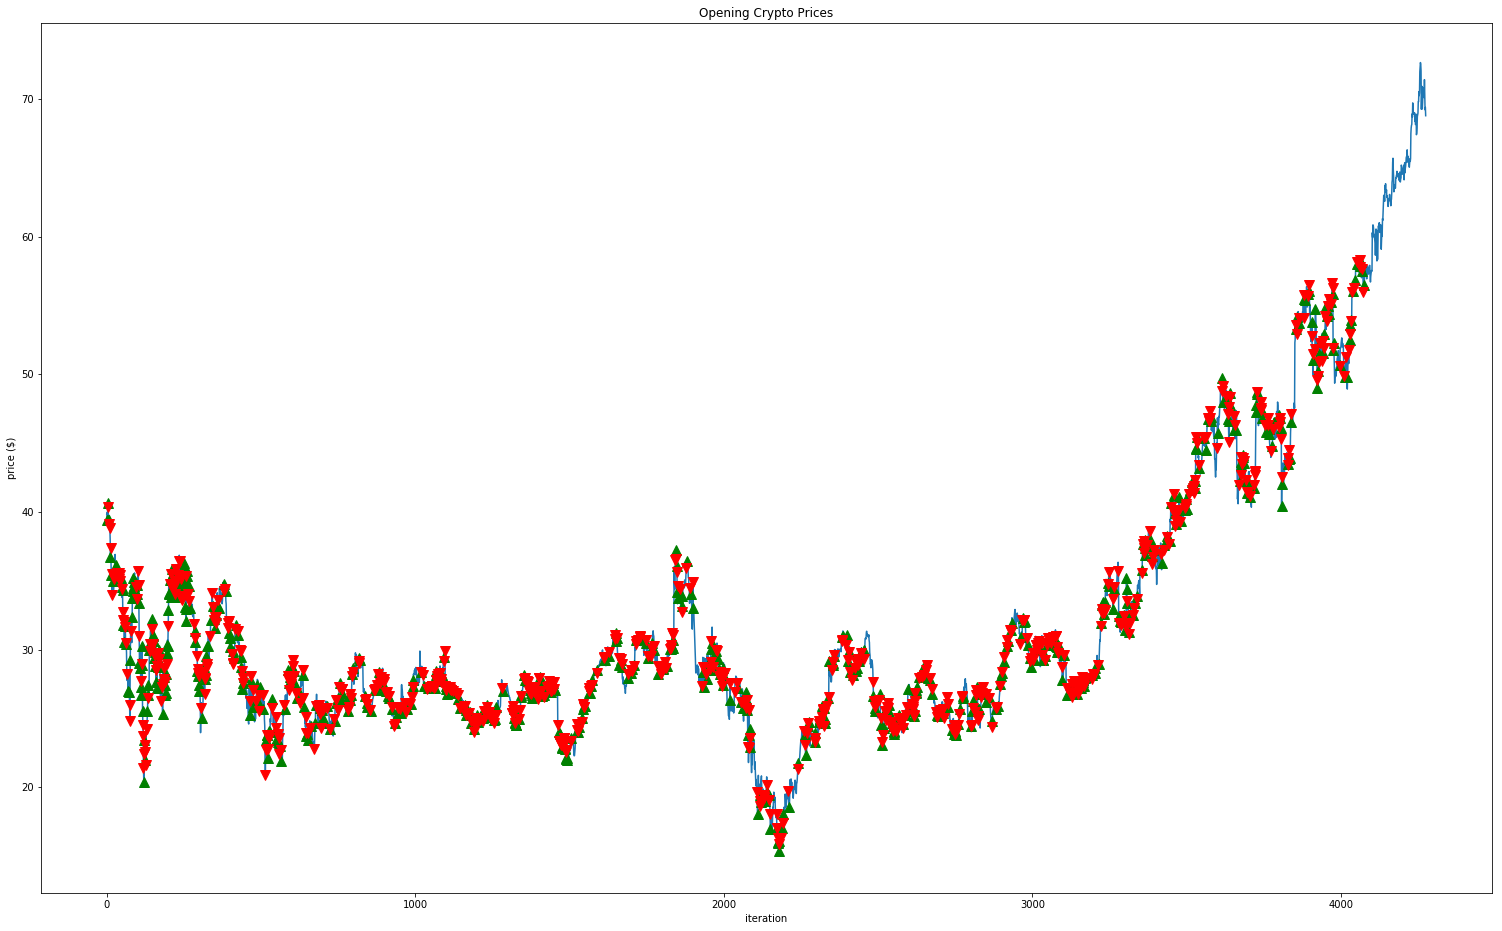

In [15]:
if __name__ == '__main__':
    #prices = getStockDataVec(stock_name, Column.OPEN, '2015-01-01','2016-01-01')
    prices = getStockDataVec(stock_name, Column.OPEN, start_date_global, end_date_global)
    
    actions = ['Buy', 'Sell', 'Hold']
    hist = 200#len(prices) #Last number of stock prices (Size of each state)
    #policy = RandomDecisionPolicy(actions)
    policy = QLearningDecisionPolicy(actions, hist + 2)
    budget = 1000.0
    num_stocks = 0
    
    #portfolio, buytrig, selltrig = run_simulation(policy, budget, num_stocks, prices, hist)
    avg, std, buytrig, selltrig = run_simulations(policy, budget, num_stocks, prices, hist)

    print(avg, std)

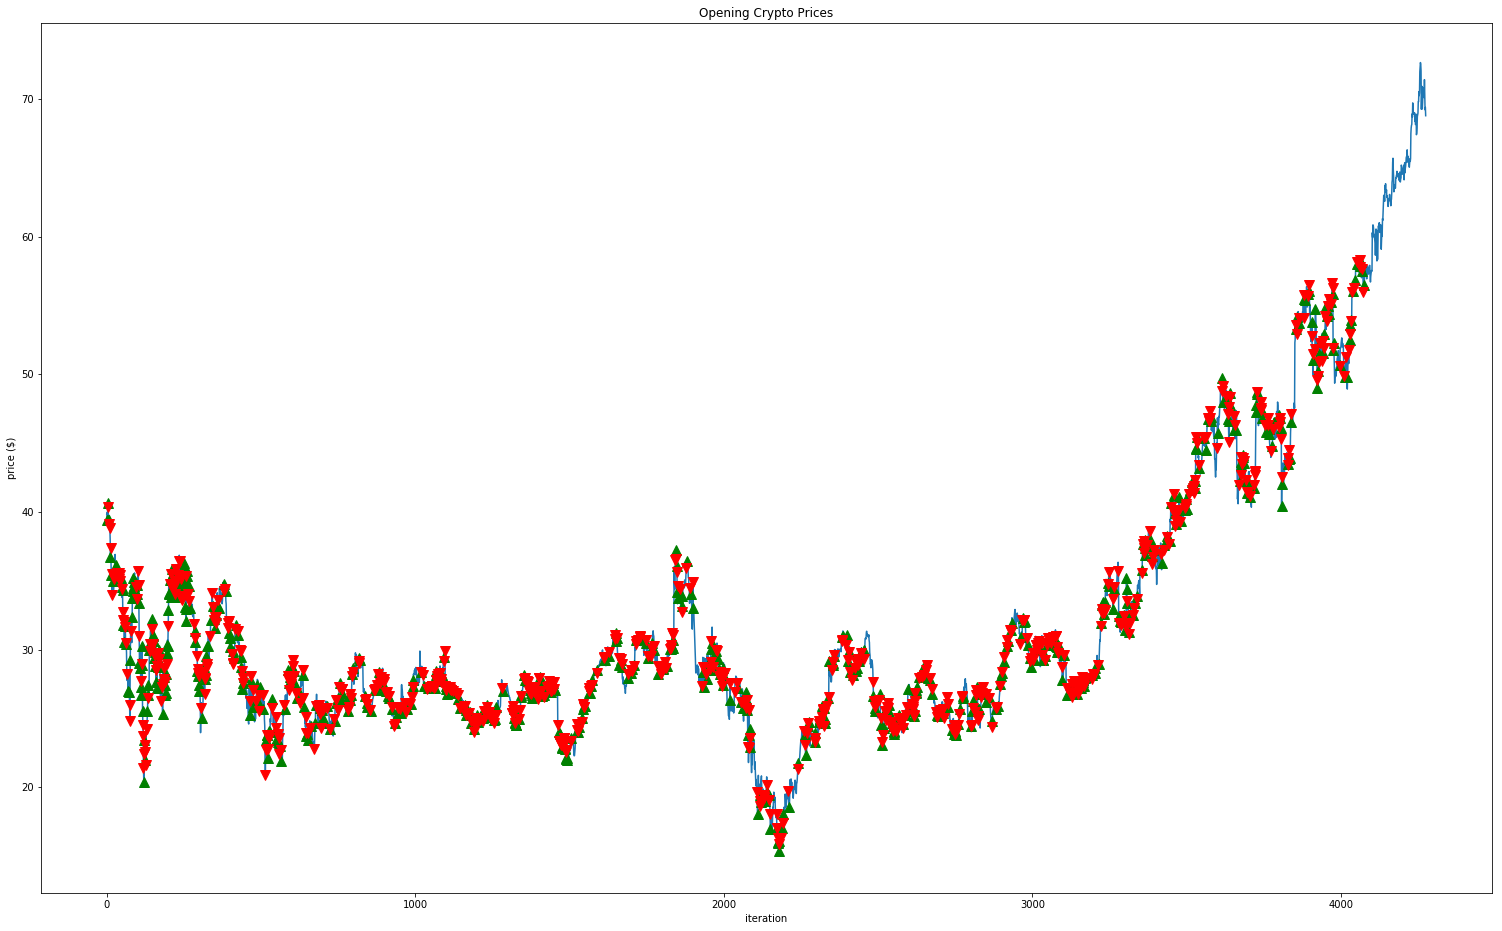

In [16]:
plot_prices(prices, buytrig, selltrig)